In [1]:
import os

from lvmdrp.utils.examples import get_frames_metadata

from lvmdrp.functions import imageMethod
from lvmdrp.functions import rssMethod

In [2]:
# define input data directory
data_path = os.path.abspath(os.path.join("..", "data", "data_simulator", "2d"))

# let's create the output directory
output_path = os.path.join("data")
os.makedirs(output_path, exist_ok=True)

# extract metadata
frames_table = get_frames_metadata(path=data_path)
# group by imagetyp, camera and exptime
frames_table = frames_table.group_by(["imagetyp", "camera", "exptime"])
# define groups and unique categories in those groups
frames_groups = frames_table.groups
unique_groups = frames_groups.keys

[INFO]: extracting metadata from 252 frames


100%|######################################################################################################| 252/252 [01:09<00:00,  3.62it/s]

[INFO]: successfully extracted metadata


In [3]:
fiberflats = frames_groups[(unique_groups["imagetyp"]=="fiberflat")&(unique_groups["camera"]=="b1")]
fiberflat_frame = fiberflats[0]
fiberflat_path = fiberflat_frame["path"]
fiberflat_camera, fiberflat_expnum = fiberflat_frame["camera"], fiberflat_frame["expnum"]

arcs = frames_groups[(unique_groups["imagetyp"]=="arc")&(unique_groups["camera"]=="b1")]
arc_frame = arcs[0]
arc_path = arc_frame["path"]
arc_camera, arc_expnum = arc_frame["camera"], arc_frame["expnum"]

In [4]:
imageMethod.subtractStraylight_drp(
    in_image=os.path.join(output_path, f"lvm-carc-{arc_camera}-{arc_expnum}.fits"),
    out_image=os.path.join(output_path, f"lvm-sarc-{arc_camera}-{arc_expnum}.fits"),
    out_stray=os.path.join(output_path, f"lvm-stray-{arc_camera}-{arc_expnum}.fits"),
    in_trace=os.path.join(output_path, f"lvm-trace-{fiberflat_camera}-{fiberflat_expnum}.fits"),
    aperture=5, poly_cross=2, smooth_disp=0, smooth_gauss=30
)

In [5]:
imageMethod.extractSpec_drp(
    in_image=os.path.join(output_path, f"lvm-sarc-{arc_camera}-{arc_expnum}.fits"),
    out_rss=os.path.join(output_path, f"lvm-xarc-{arc_camera}-{arc_expnum}.fits"),
    in_trace=os.path.join(output_path, f"lvm-trace-{fiberflat_camera}-{fiberflat_expnum}.fits"),
    method="aperture", aperture=4, plot=1, parallel="auto"
)

In [85]:
from lvmdrp.core import rss
import matplotlib.pyplot as plt
import numpy as np


CHANNEL_WL = {"b1": (3600, 5930), "r1": (5660, 7720), "z1": (7470, 9800)}
wave_range = CHANNEL_WL["b1"]

xarc = rss.loadRSS(os.path.join(output_path, f"lvm-xarc-{arc_camera}-{arc_expnum}.fits"))
xarc._data = xarc._data[:, ::-1]
xarc.setWave(np.linspace(*wave_range, xarc._data.shape[1]))

In [95]:
from astroquery.nist import Nist
from astropy import units as u

# table = Nist.query(minwav=wave_range[0]*u.AA, maxwav=wave_range[1]*u.AA, linename="Hg I", output_order="wavelength", wavelength_type="vac+air")
table

Spectrum,Observed,Ritz,Transition,Rel.,Aki,fik,Acc.,Ei Ek,Lower level,Upper level,Type,TP,Line
str5,float64,str9,float64,str5,float64,float64,str2,str27,str23,str27,int64,str5,str11
Cd I,3610.5077,3610.508,27689.038,1000,130000000.0,0.36,D,3.94603913 - 7.3790423,4d10.5s.5p | 3P* | 2,4d10.5s.5d | 3D | 3,--,T4515,L3486
Cd I,3612.8729,3612.8724,27670.912,800,35000000.0,0.069,D,3.94603913 - 7.37679547,4d10.5s.5p | 3P* | 2,4d10.5s.5d | 3D | 2,--,T4515,L3486
Cd I,3614.4529,3614.4529,27658.816,60,--,--,--,3.94603913 - 7.37529526,4d10.5s.5p | 3P* | 2,4d10.5s.5d | 3D | 1,--,--,L3486
Cd I,3649.5584,3649.5568,27392.77,20,--,--,--,3.94603913 - 7.34231125,4d10.5s.5p | 3P* | 2,4d10.5s.5d | 1D | 2,--,--,L3486
Cd II,3666.756,3666.736+,27264.3,20,270000.0,0.00081,C,11.120050 - 14.500411,4d10.5d | 2D | 3/2,4d9.5s.(3D).5p | 2F* | 5/2,--,T3096,L3540
Cd II,3826.71,3826.706+,26124.7,15,50000.0,7e-05,D,8.587010 - 11.826063,4d9.5s2 | 2D | 5/2,4d10.6p | 2P* | 3/2,--,T3096,L3540
Cd II,3957.244,3957.230+,25262.96,15,300000.0,0.00106,C,11.120050 - 14.252269,4d10.5d | 2D | 3/2,4d9.5s.(3D).5p | 4D* | 5/2,--,T3096,L3540
Cd I,3981.9257,3981.9257,25106.376,10,--,--,--,5.41716521 - 8.5299591,4d10.5s.5p | 1P* | 1,4d10.5s.9s | 1S | 0,--,--,L3486
Cd II,4006.867,4006.862+,24950.1,20,--,--,--,11.139209 - 14.232631?,4d10.5d | 2D | 5/2,4d9.5s.(3D).5p | 4D* | 7/2,--,--,L3540


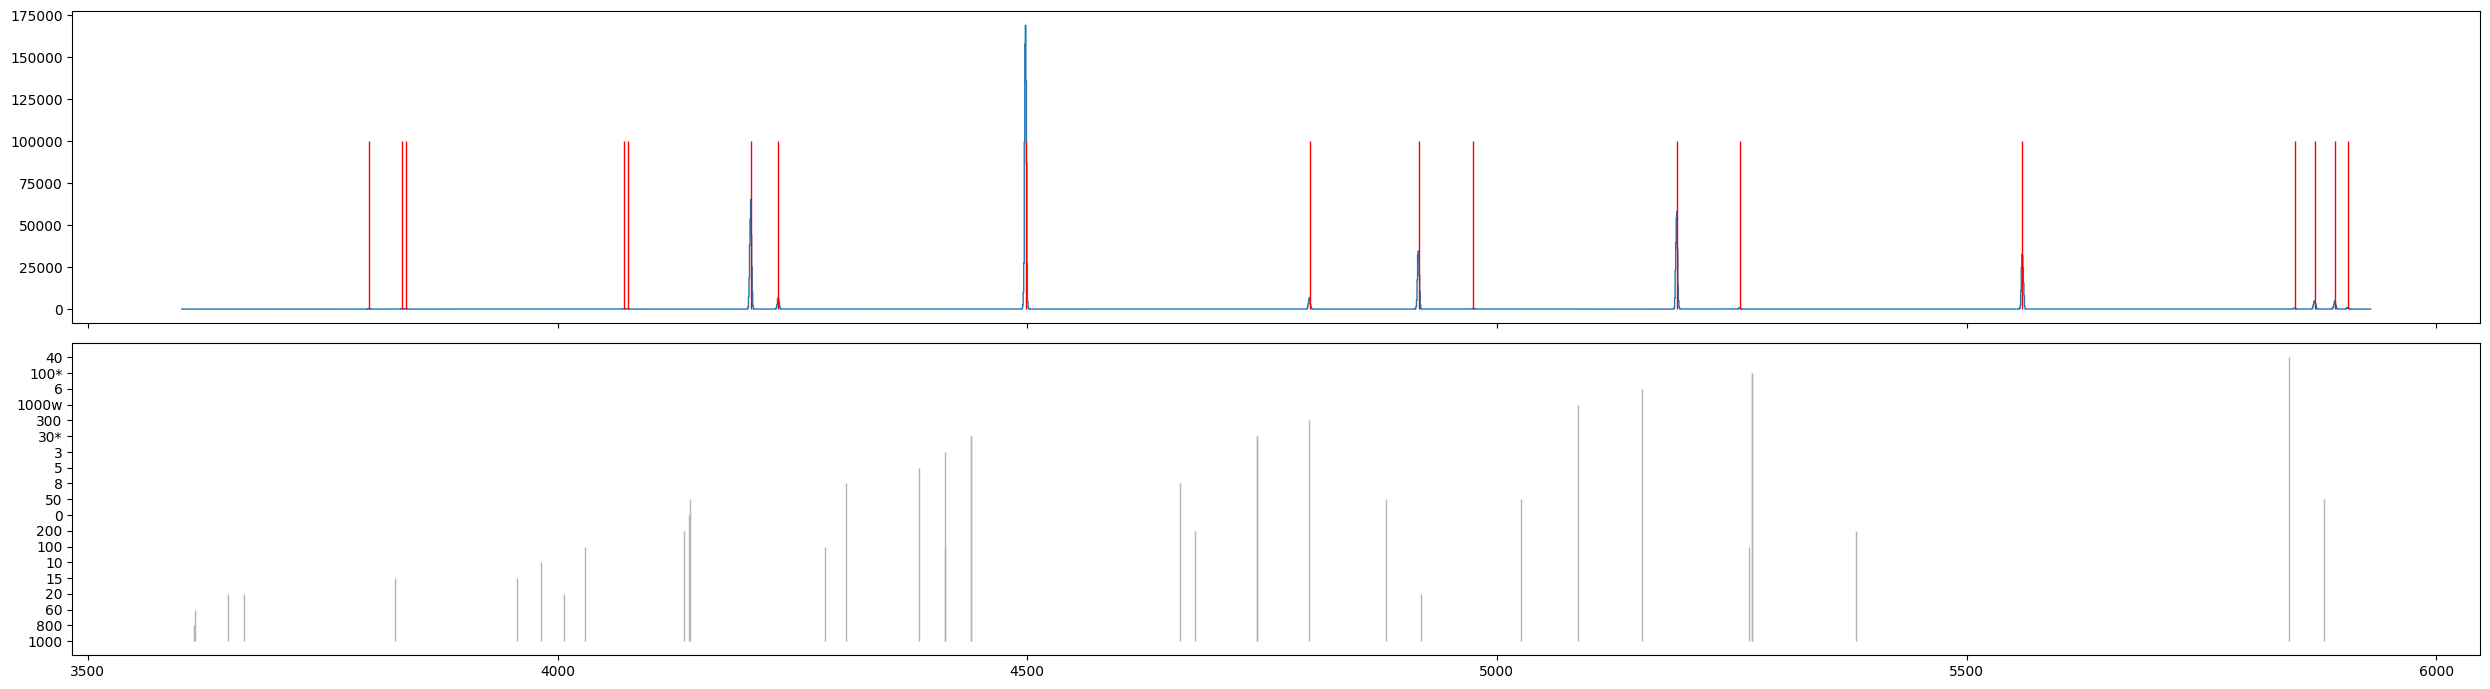

In [97]:
fig, axs = plt.subplots(2, 1, figsize=(25,7), sharex=True)

ised = 300

ref_spec = xarc.getSpec(ised)

pix, wav, _ = ref_spec.findPeaks()

axs[0].step(ref_spec._wave, ref_spec._data, lw=1)
axs[0].vlines(wav, 0, 1e5, colors="r", lw=1)

axs[1].vlines(table["Observed"], 0, table["Rel."], colors="0.7", lw=1)

fig.tight_layout()